# STEAM VIDEO GAMES RECOMMENDATION SYSTEM

We need to recommend the similar games to the user based on their behaviour

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
data=pd.read_csv('steam-200k.csv')
data.head()

,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


#Basic EDA

In [ ]:
# renaming the column name as games user_id, hoursplay and status
data=data.rename(columns={'151603712':'User_ID'})
data=data.rename(columns={'The Elder Scrolls V Skyrim':'Games'})
data=data.rename(columns={'purchase':'Status'})
data=data.rename(columns={'1.0':'Hoursplay'})
data

,User_ID,Games,Status,Hoursplay,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0
...,...,...,...,...,...
199994,128470551,Titan Souls,play,1.5,0
199995,128470551,Grand Theft Auto Vice City,purchase,1.0,0
199996,128470551,Grand Theft Auto Vice City,play,1.5,0
199997,128470551,RUSH,purchase,1.0,0


In [ ]:
#dropping 0 column
data=data.drop(columns=['0'])
data

,User_ID,Games,Status,Hoursplay
0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,151603712,Fallout 4,purchase,1.0
2,151603712,Fallout 4,play,87.0
3,151603712,Spore,purchase,1.0
4,151603712,Spore,play,14.9
...,...,...,...,...
199994,128470551,Titan Souls,play,1.5
199995,128470551,Grand Theft Auto Vice City,purchase,1.0
199996,128470551,Grand Theft Auto Vice City,play,1.5
199997,128470551,RUSH,purchase,1.0


In [ ]:
#dropping duplicate user_id and games keep the last one
data=data.drop_duplicates(['User_ID','Games'],keep='last')

In [ ]:
data.shape

(128804, 4)

In [ ]:
data.columns

Index(['User_ID', 'Games', 'Status', 'Hoursplay'], dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128804 entries, 0 to 199998
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   User_ID    128804 non-null  int64  
 1   Games      128804 non-null  object 
 2   Status     128804 non-null  object 
 3   Hoursplay  128804 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.9+ MB


In [ ]:
data.isnull().sum()

User_ID      0
Games        0
Status       0
Hoursplay    0
dtype: int64

In [ ]:
data['Games'].value_counts()

Dota 2                              4841
Team Fortress 2                     2323
Unturned                            1563
Counter-Strike Global Offensive     1412
Half-Life 2 Lost Coast               981
                                    ... 
iBomber Attack                         1
The Dreamatorium of Dr. Magnus 2       1
Verde Station                          1
TRIP Steam Edition                     1
Executive Assault                      1
Name: Games, Length: 5155, dtype: int64

In [ ]:
# Let's get the total count of play and total count of purchase
total_purchase=data.groupby('Status')['Status'].agg('count')
total_purchase

Status
play        70205
purchase    58599
Name: Status, dtype: int64

In [ ]:
data.describe()

,User_ID,Hoursplay
count,1.288040e+05,128804.000000
mean,1.025343e+08,27.150648
std,7.242875e+07,171.276192
min,5.250000e+03,0.100000
25%,4.559264e+07,1.000000
50%,8.605570e+07,1.000000
75%,1.542307e+08,5.700000
max,3.099031e+08,11754.000000


## Visualizing data

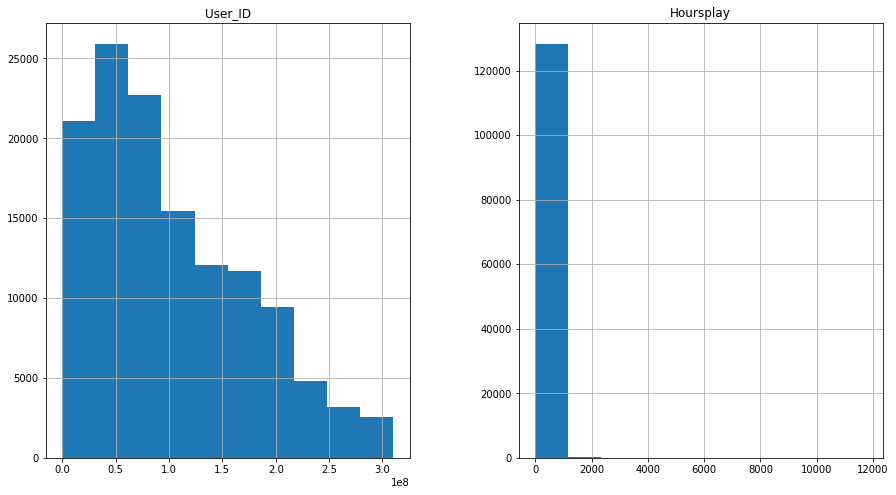

In [ ]:
data.hist(figsize=(15,8))
plt.show()

Text(0.5, 1.0, 'Status column frequency')

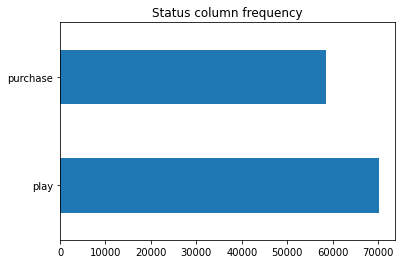

In [ ]:
data['Status'].value_counts().plot.barh().set_title('Status column frequency')

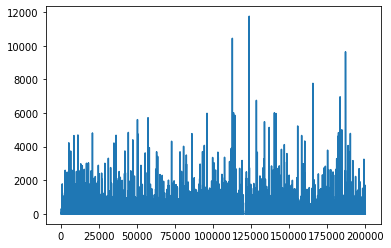

In [ ]:
data['Hoursplay'].plot()

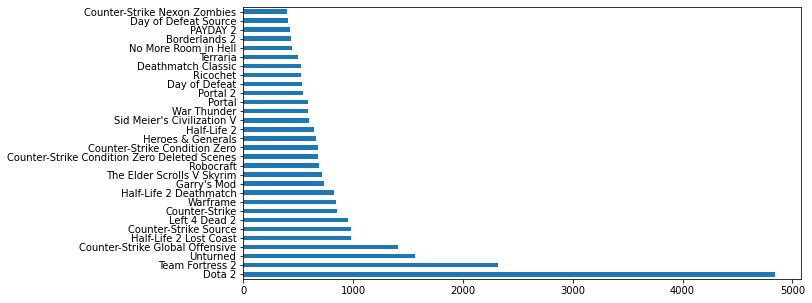

In [ ]:
data['Games'].value_counts().head(30).plot(kind='barh',figsize=(10,5))

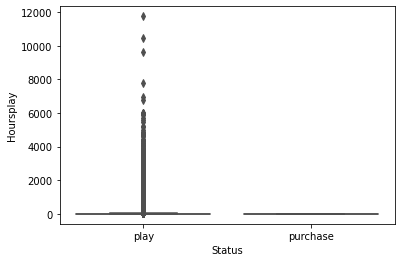

In [ ]:
sns.boxplot(x='Status',y='Hoursplay',data=data,palette='rainbow')

# Converting hours to rating

In [ ]:
data=data[(data['Hoursplay']>=2) & (data['Status']=='play')]
data_filtered=data[data.groupby('Games').User_ID.transform(len)>=20]
data_filtered['Games'].nunique()
data_filtered.head(20)

data_filtered['User_ID']=data_filtered['User_ID'].astype(str)
averages=data_filtered.groupby(['Games'],as_index=False).Hoursplay.mean()
averages['avg_Hoursplay']=averages['Hoursplay']
averages.drop('Hoursplay',axis=1,inplace=True)

final_ratings=pd.merge(data_filtered,averages[['Games','avg_Hoursplay']],on='Games')
conditions=[
    (final_ratings['Hoursplay']>=0.8*final_ratings['avg_Hoursplay']),
    (final_ratings['Hoursplay']>=0.6*final_ratings['avg_Hoursplay'])&(final_ratings['Hoursplay']<0.8*final_ratings['avg_Hoursplay']),
    (final_ratings['Hoursplay']>=0.4*final_ratings['avg_Hoursplay'])&(final_ratings['Hoursplay']<0.6*final_ratings['avg_Hoursplay']),
    (final_ratings['Hoursplay']>=0.2*final_ratings['avg_Hoursplay'])&(final_ratings['Hoursplay']<0.4*final_ratings['avg_Hoursplay']),
    final_ratings['Hoursplay']>=0,
]
values=[5,4,3,2,1]
final_ratings['rating']=np.select(conditions,values)
final_ratings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,User_ID,Games,Status,Hoursplay,avg_Hoursplay,rating
0,151603712,The Elder Scrolls V Skyrim,play,273.0,115.351792,5
1,59945701,The Elder Scrolls V Skyrim,play,58.0,115.351792,3
2,92107940,The Elder Scrolls V Skyrim,play,110.0,115.351792,5
3,250006052,The Elder Scrolls V Skyrim,play,465.0,115.351792,5
4,11373749,The Elder Scrolls V Skyrim,play,220.0,115.351792,5
...,...,...,...,...,...,...
36415,51822361,"Warhammer 40,000 Dawn of War Soulstorm",play,23.0,14.109091,5
36416,38317154,"Warhammer 40,000 Dawn of War Soulstorm",play,5.5,14.109091,2
36417,36404933,"Warhammer 40,000 Dawn of War Soulstorm",play,5.8,14.109091,3
36418,87201181,"Warhammer 40,000 Dawn of War Soulstorm",play,24.0,14.109091,5


In [ ]:
# keeping only important columns( user_id, games,rating ) and dropping everthing else 
final_ratings=final_ratings.drop(['Status','Hoursplay','avg_Hoursplay'],axis=1)
final_ratings

,User_ID,Games,rating
0,151603712,The Elder Scrolls V Skyrim,5
1,59945701,The Elder Scrolls V Skyrim,3
2,92107940,The Elder Scrolls V Skyrim,5
3,250006052,The Elder Scrolls V Skyrim,5
4,11373749,The Elder Scrolls V Skyrim,5
...,...,...,...
36415,51822361,"Warhammer 40,000 Dawn of War Soulstorm",5
36416,38317154,"Warhammer 40,000 Dawn of War Soulstorm",2
36417,36404933,"Warhammer 40,000 Dawn of War Soulstorm",3
36418,87201181,"Warhammer 40,000 Dawn of War Soulstorm",5


# MEMORY BASED COLLABORATIVE FILTERING

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [ ]:
# creating pivot table containing user_id as index, games as columns, ratings as values
piv=final_ratings.pivot_table(index=['User_ID'],columns=['Games'],values='rating')

In [ ]:
print(piv.shape)
piv.head()

(8309, 427)


Games,7 Days to Die,APB Reloaded,ARK Survival Evolved,Ace of Spades,AdVenture Capitalist,Aftermath,Age of Chivalry,Age of Empires II HD Edition,Age of Empires III Complete Collection,Age of Mythology Extended Edition,...,"Warhammer 40,000 Dawn of War II - Chaos Rising","Warhammer 40,000 Space Marine",Wasteland 2,Watch_Dogs,Wolfenstein The New Order,Worms Reloaded,Worms Revolution,XCOM Enemy Unknown,Zombie Panic Source,theHunter
User_ID,,,,,,,,,,,,,,,,,,,,,
100053304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100057229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100070732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100096071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100168166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Please Note: As we are subtracting the mean from each rating to standardize
##all users with only one rating or who had rated everything the same will be dropped
# Normalizing the values in pivot table
piv_norm=piv.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)),axis=1)


# Dropping all columns containing only zeros representing users who did not rate
piv_norm.fillna(0,inplace=True)
piv_norm=piv_norm.T
piv_norm=piv_norm.loc[:,(piv_norm !=0).any(axis=0)]

In [ ]:
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator

In [ ]:
# converting the data into sparse matrix format to be read by the following functions
piv_sparse=sp.sparse.csr_matrix(piv_norm.values)


In [ ]:
# creating matrices to show the computed cosine similarity values between each user/user array pair and item/item array pair.
item_similarity=cosine_similarity(piv_sparse)
user_similarity=cosine_similarity(piv_sparse.T)


In [ ]:
# Inserting the similarity matricies into dataframe objects
#item similarity dataframe
item_sim_df=pd.DataFrame(item_similarity,index=piv_norm.index,columns=piv_norm.index)
#user similarity dataframe
user_sim_df=pd.DataFrame(user_similarity,index=piv_norm.columns,columns=piv_norm.columns)

In [ ]:
#Let's write a function which will return the top 10 games with the highest cosine similarity value
def top_game(Game):
  count=1
  print('Similar games to {} include:\n'.format(Game))
  for item in item_sim_df.sort_values(by=Game, ascending=False).index[1:11]:
    print('No. {}: {}'.format(count,item))
    count+=1

In [ ]:
top_game('Aftermath')

Similar games to Aftermath include:

No. 1: Alice Madness Returns
No. 2: Shadow Warrior
No. 3: Brtal Legend
No. 4: Resident Evil 5 / Biohazard 5
No. 5: Infestation Survivor Stories
No. 6: Call of Juarez Gunslinger
No. 7: The Walking Dead Season Two
No. 8: Counter-Strike Nexon Zombies
No. 9: Star Conflict
No. 10: L.A. Noire


In [ ]:
piv_norm.columns

Index(['100057229', '100096071', '100311267', '100322840', '100351493',
       '100359523', '100431715', '100444456', '100519466', '100630947',
       ...
       '994489', '9946133', '99484728', '99640715', '99704390', '99711581',
       '99713453', '99723205', '99766416', '99802512'],
      dtype='object', name='User_ID', length=3056)

In [ ]:
# writing a function which will return the top 5 users with the highest similarity value 
def top_users(user):
  if user not in piv_norm.columns:
    return('No data available on user {}'.format(user))

  print('Most Similar Users:\n')
  sim_values=user_sim_df.sort_values(by=user,ascending=False).loc[:,user].tolist()[1:11]
  sim_users=user_sim_df.sort_values(by=user,ascending=False).index[1:11]

  zipped=zip(sim_users,sim_values,)
  for user, sim in zipped:
    print('User #{0}, Similarity value:{1:.2f}'.format(user, sim))

In [ ]:
top_users('99484728')

Most Similar Users:

User #40289887, Similarity value:0.73
User #185494712, Similarity value:0.71
User #16710264, Similarity value:0.71
User #20566124, Similarity value:0.67
User #49769103, Similarity value:0.67
User #15702351, Similarity value:0.65
User #161139120, Similarity value:0.59
User #202057920, Similarity value:0.58
User #57271785, Similarity value:0.58
User #33993318, Similarity value:0.58


In [ ]:
# writing a function which constructs a list of lists containing the highest rated games per similar user
# and returns the name of the game along with the frequency it appears in the list
def similar_user_recs(user):
  if user not in piv_norm.columns:
    return('No data available on user {}'.format(user))
  sim_users=user_sim_df.sort_values(by=user, ascending=False).index[1:11]
  best=[]
  most_common={}

  for i in sim_users:
    max_score=piv_norm.loc[:,i].max()
    best.append(piv_norm[piv_norm.loc[:,i]==max_score].index.tolist())
  for i in range(len(best)):
    for j in best[i]:
      if j in most_common:
        most_common[j]+=1
      else:
        most_common[j]=1
  sorted_list=sorted(most_common.items(),key=operator.itemgetter(1),reverse=True)
  return sorted_list[:5]


In [ ]:
similar_user_recs('100519466')


[('Robocraft', 6),
 ('BLOCKADE 3D', 2),
 ("Garry's Mod", 2),
 ('ARK Survival Evolved', 1),
 ('Dino D-Day', 1)]

# COLLABORATIVE FILTERING USING KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors

model_knn=NearestNeighbors(metric='cosine',algorithm='brute',n_neighbors=20,n_jobs=-1)

model_knn.fit(piv_norm)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)


Let's test model and make some recommendations:

In [ ]:
# choosing random game
query_index=np.random.choice(piv_norm.shape[0])

print('Chosen game is:',piv_norm.index[query_index])

# using kNN algorithm to measures distance to determine the closeness of instances.
distances,indices=model_knn.kneighbors(piv_norm.iloc[query_index,:].values.reshape(1,-1),n_neighbors=6)

# picking most popular games among the neighbors and printing their names
for i in range(0,len(distances.flatten())):
  if i ==0:
    print('recommendations for {0}:\n'.format(piv_norm.index[query_index]))
  else:
    print('{0}:{1}, with distance of {2}:'.format(i,piv_norm.index[indices.flatten()[i]],distances.flatten()[i]))

Chosen game is: Dust An Elysian Tail
recommendations for Dust An Elysian Tail:

1:Monaco, with distance of 0.8380965886521103:
2:S.T.A.L.K.E.R. Shadow of Chernobyl, with distance of 0.8751285258201734:
3:Endless Legend, with distance of 0.8838793177671124:
4:Dino D-Day, with distance of 0.8855616702316731:
5:Awesomenauts, with distance of 0.8861847163760568:


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


#Conclusion

We can use different methods based on our problem statement and dataset. Here I used collaborative filtering technique to recommend games.We can use this method to recommend a lot of other things as well such as music, movies, books, news etc. 